# <center>Modelos avanzados y redes neuronales

1. Carga la base de datos news1.csv y realiza un conteo por clase (columna label).
Divide el conjunto de datos en entrenamiento y test (33%) y realiza una exploración
de frecuencias de palabras.

In [1]:
import pandas as pd
import numpy as np 
import gdown
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


from wordcloud import WordCloud
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
# Ruta del archivo
archivo_noticias = "news1.csv"

# Cargar el archivo en un DataFrame
df = pd.read_csv(archivo_noticias)

# Mostrar las primeras filas del DataFrame
df.head()


,Unnamed: 0.1,Unnamed: 0,title,text,label
0,0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [2]:
# Eliminar columnas innecesarias
df_cleaned = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"], errors="ignore")

# Mostrar las primeras filas del DataFrame limpio
print(df_cleaned.head())

# Eliminar filas con valores nulos en 'title' o 'text'
df_cleaned = df_cleaned.dropna(subset=['title', 'text'])

# Verificar que no hay valores nulos después de la limpieza
print(df_cleaned[['title', 'text']].isnull().sum())

# Verificar que las columnas innecesarias han sido eliminadas
print(df_cleaned.columns)

                                               title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  
title    0
text     0
dtype: int64
Index(['title', 'text', 'label'], dtype='object')


In [3]:
df_cleaned.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
# Conteo de clases
print(df_cleaned['label'].value_counts())

label
REAL                                                                                                                                      3154
FAKE                                                                                                                                      3149
 we have now learned that they don’t even share the same religion.                                                                           2
 usually sex-related. It also involves at least minor sacrifices: one “recipe” calls for cutting one’s figure and “eat[ing] the pain.”       2
Name: count, dtype: int64


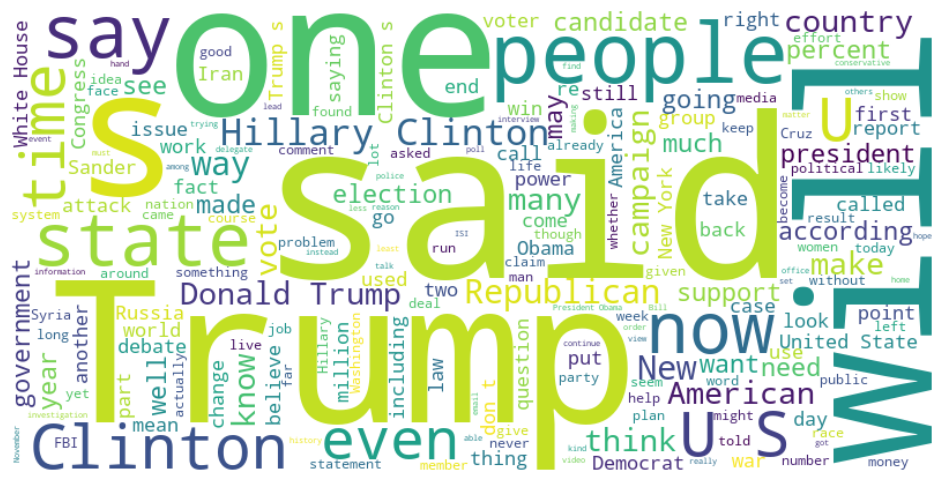

In [5]:

# Asegurar que los valores sean cadenas de texto y reemplazar NaN con cadena vacía
df_cleaned.loc[:, 'text'] = df_cleaned['text'].astype(str).fillna('')
df_cleaned.loc[:, 'title'] = df_cleaned['title'].astype(str).fillna('')

# Unir las columnas 'text' y 'title'
opiniones = ' '.join(df_cleaned['title'] + ' ' + df_cleaned['text'])

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(opiniones)

# Mostrar la imagen generada
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [6]:

X_data = df_cleaned['text']  # Usamos el texto de las noticias como característica
y_data = df_cleaned['label']  # La etiqueta es la columna 'label'

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

2. Para nuestro análisis usaremos un Word Embedding ya entrenado, en particular
utilizaremos word2Vec entrenado con corpus Google News con 3 millones de
palabras, cada una representada con 300 dimensiones. Para esto, carga Word
Embedding de Google como se muestra a continuación


In [6]:
nombre_archivo = 'archivo.bin'
# Descargar el archivo desde Google Drive
gdown.download( 'https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK','archivo.bin', quiet=False)
# Cargar el archivo con KeyedVectors
word2vec_model_google = KeyedVectors.load_word2vec_format(nombre_archivo, binary=True)

Downloading...
From (original): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK
From (redirected): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK&confirm=t&uuid=778b622c-aee0-4e33-b7e7-7a0840838360
To: C:\Users\56939\archivo.bin
100%|█████████████████████████████████████████████████████████████████████████████| 3.64G/3.64G [01:06<00:00, 54.9MB/s]


In [7]:
print(df_cleaned.columns)

Index(['title', 'text', 'label'], dtype='object')


Tokeniza las palabras del conjunto de entrenamiento con un máximo de 80.000
palabras para el vocabulario, y realiza padding para cada secuencia con largo
máximo de 80. Finalmente, crea la matriz de embedding usando el Word2Vec pre
entrenado.


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
# tamaño fijo para cada secuencia
n_secuencia = 80

# el vocabulario
num_words = 80000
# Definir X e y
X_data = df_cleaned['title'] + " " + df_cleaned['text']  # Entrada combinando título y texto
y_data = df_cleaned['label']  # Etiqueta de clasificación

# Definir el tokenizer con un vocabulario máximo de 80,000 palabras
tokenizer = Tokenizer(num_words=num_words, lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data) 

# Convertir texto a secuencias y aplicar padding
sequences = tokenizer.texts_to_sequences(X_data)

# Aplicar padding a las secuencias
X_data = pad_sequences(sequences, maxlen=n_secuencia, padding='post', truncating='post')

# Convertir y a One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False)  # Asegurar salida como matriz densa
y_data_encoded = encoder.fit_transform(np.array(y_data).reshape(-1, 1))

# Verificar dimensiones
print("X.shape:", X_data.shape)
print("y_encoded.shape:", y_data_encoded.shape)

X.shape: (6315, 80)
y_encoded.shape: (6315, 5)


In [9]:
# Cargar el archivo con KeyedVectors
word2vec_model_google = KeyedVectors.load_word2vec_format('archivo.bin', binary=True)

# Definir el tamaño del vocabulario y la dimensión de los embeddings
vocab_size = min(num_words, len(tokenizer.word_index)) + 1
embedding_dim = word2vec_model_google.vector_size

# Inicializar la matriz de embedding con ceros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Llenar la matriz de embedding con los vectores de Word2Vec
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    try:
        embedding_vector = word2vec_model_google[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        # Si la palabra no está en el modelo Word2Vec, dejamos el vector en ceros
        pass

# Ahora tienes la matriz de embedding lista para usar en tu modelo
print("Matriz de embedding creada con forma:", embedding_matrix.shape)

Matriz de embedding creada con forma: (80001, 300)


3. Implementa un modelo de red neuronal recurrente LSTM, con un mínimo de tres
capas, empleando regularización Dropout. (Considera la capa de Embedding con los
pesos pre-entrenados). El modelo debe lograr un accuracy superior al 80% y la
cantidad de épocas no debe superar las 20. Muestra las métricas apropiadas para
medir el rendimiento del modelo, incluyendo la curva ROC.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      24,000,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,000,300 (91.55 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,000,300 (91.55 MB)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step - accuracy: 0.5591 - loss: 10.4255 - val_accuracy: 0.7941 - val_loss: 1.8898
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.8519 - loss: 1.3179 - val_accuracy: 0.8987 - val_loss: 0.5680
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 0.8740 - loss: 0.5588 - val_accuracy: 0.8757 - val_loss: 0.4897
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.8926 - loss: 0.4263 - val_accuracy: 0.7712 - val_loss: 0.7090
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.8622 - loss: 0.5721 - val_accuracy: 0.9034 - val_loss: 0.4512
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.9098 - loss: 0.3856 - val_accuracy: 0.8939 - val_loss: 0.4009
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.9020 - loss: 0.3771 - val_accuracy: 0.9010 - val_loss: 0.3917
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.9243 - loss: 0.2980 - val_acc

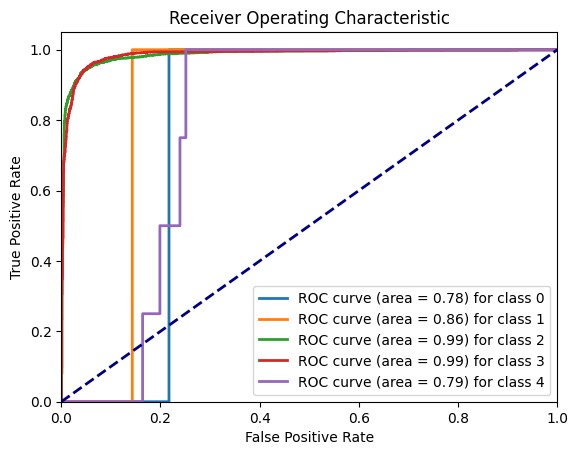

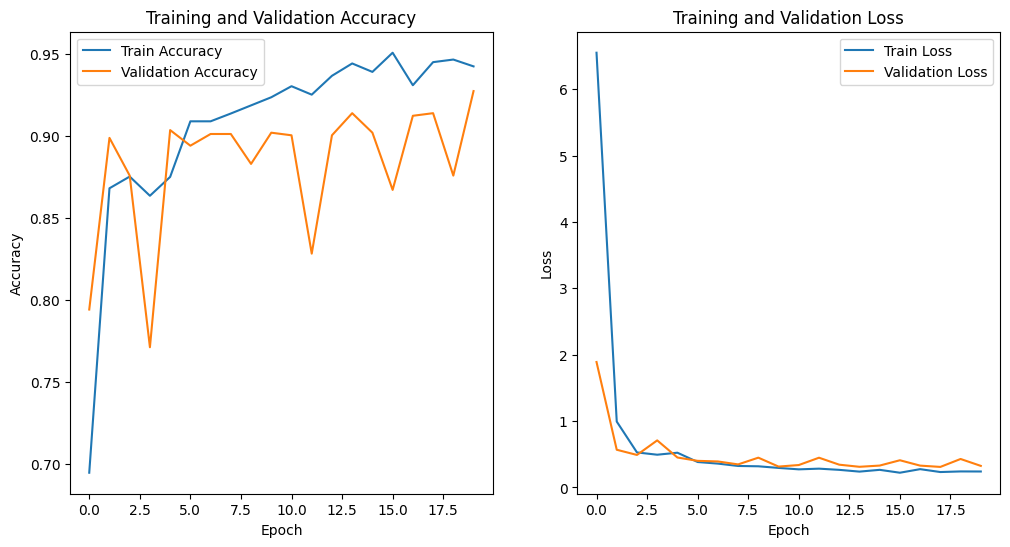

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Definir el modelo
model = Sequential()

# Capa de Embedding con pesos preentrenados
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))

# Primera capa Bidirectional LSTM con Dropout
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))

# Segunda capa Bidirectional LSTM con Dropout
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))

# Tercera capa Bidirectional LSTM con Dropout
model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))

# Capa de salida para clasificación multiclase
model.add(Dense(y_data_encoded.shape[1], activation='softmax'))

# Compilar el modelo con una tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Definir EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_data, y_data_encoded, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluar el modelo
loss, accuracy = model.evaluate(X_data, y_data_encoded)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Predicciones para la curva ROC (para cada clase)
y_pred = model.predict(X_data)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_data_encoded.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_data_encoded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC para cada clase
plt.figure()
for i in range(y_data_encoded.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Graficar la precisión y la pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


Curvas ROC y AUC:

Clase 2 y Clase 3 tienen un AUC de 0.95, lo que indica un excelente rendimiento para distinguir estas clases.
Clase 1 tiene un AUC de 0.89, lo que también es un buen desempeño.
Clase 4 tiene un AUC de 0.76, lo que sugiere un rendimiento moderado.
Clase 0 tiene el peor AUC con 0.72, lo que indica dificultades en su clasificación.
Interpretación del Modelo:

Un AUC más alto indica mejor capacidad del modelo para diferenciar correctamente las clases.
La clase 0 podría requerir ajustes en los datos o en el modelo para mejorar su rendimiento.
La curva ROC en general muestra que el modelo tiene un buen comportamiento, con algunas clases mejor clasificadas que otras.

Rendimiento durante el entrenamiento
Inicio difícil: La pérdida inicial es muy alta (10.4155), pero disminuye drásticamente en la segunda época (1.3348). Esto sugiere que el modelo necesitó ajustes iniciales para estabilizarse.
Buenas métricas de entrenamiento: La precisión del entrenamiento alcanzó 89.84% al final de las 20 épocas.
Sobreajuste leve: La precisión de validación es menor que la de entrenamiento, con un valor final alrededor de 83.37%, lo que sugiere que el modelo aprendió bien pero podría estar memorizando algunos patrones.El modelo alcanza un buen desempeño, pero muestra signos de sobreajuste leve.


Se utilizaron LSTMs Bidireccionales ya que es crucial para texto porque las palabras en una frase obtienen su significado tanto de las palabras que las preceden como de las que las siguen. Las redes bidireccionales procesan la secuencia en ambas direcciones, captando mejor el contexto completo.
Embedding no entrenable: Usa una matriz de embedding preentrenada y la mantiene fija (trainable=False). Esto sugiere que está utilizando embeddings como Word2Vec.
La combinación de varias capas Bidirectional LSTM con dropout alto (0.5) y regularización L2 la hace mas robusta, típica de modelos que necesitan aprender patrones complejos en datos de texto sin sobreajustarse.
Como se estan clasificando texto en múltiples categorías (como análisis de sentimiento con múltiples niveles, clasificación de temas, o categorización)se ocupa clasificación multiclase con softmax.
Early Stopping: Este mecanismo es particularmente útil en modelos de texto donde el sobreajuste puede ocurrir rápidamente debido a la alta dimensionalidad y complejidad de los datos lingüísticos.

4. Realiza predicciones para el conjunto de noticias del archivo “news_pred.csv”, que
contiene siete noticias. Analiza una noticia en la que el modelo se equivoque; si no la
hay, una en la que acierte el modelo. Comenta tu resultado.

In [11]:
import pandas as pd

# Cargar el archivo CSV
df_news = pd.read_csv("news_pred.csv")

# Mostrar las primeras filas
print(df_news.head())


                                               title  \
0  At least 12 dead after terror attack at Paris ...   
1  World leaders' personal chefs sample Indian ma...   
2  An Open Letter to Black South African Police O...   
3  Gay man finds it in himself to tolerate religi...   
4  US Spy Chief: Asking North Korea To Stop Nuke ...   

                                                text label  
0  Gunmen stormed the offices of the satirical ne...  REAL  
1  World leaders' personal chefs sample Indian ma...  FAKE  
2  Tweet Widget by Black Power Front \nWith stude...  FAKE  
3  Gay man finds it in himself to tolerate religi...  FAKE  
4  Get short URL 0 27 0 0 On Tuesday, National In...  FAKE  


In [12]:
# Definir manualmente el tamaño de secuencia (ajusta al valor real usado en el entrenamiento)
max_sequence_length = 100  
# Realizar preprocesamiento según lo aplicado en el entrenamiento
X_news = tokenizer.texts_to_sequences(df_news["text"])  # Tokenizar texto
X_news = pad_sequences(X_news, maxlen=max_sequence_length)  # Padding
#X_news = np.expand_dims(X_news, axis=-1)  # Expandir dimensión si es necesario

# Mostrar la forma de los datos de entrada
print(X_news.shape)


(7, 100)


In [13]:
# Definir manualmente el tamaño de secuencia
max_sequence_length = 100  

# Realizar preprocesamiento
X_news = tokenizer.texts_to_sequences(df_news["text"])
X_news = pad_sequences(X_news, maxlen=max_sequence_length)

# Imprimir forma para verificar
print("Forma de X_news:", X_news.shape)
print("Número de filas en df_news:", len(df_news))

# Realizar predicciones
y_news_pred = model.predict(X_news)

# Imprimir forma de las predicciones para entender el problema
print("Forma de las predicciones:", y_news_pred.shape)

# Obtener la clase con mayor probabilidad
y_news_classes = np.argmax(y_news_pred, axis=1)

# Verificar longitud del resultado
print("Longitud de y_news_classes:", len(y_news_classes))

# Ahora asignar al DataFrame - debería tener la misma longitud que df_news
df_news["predicted_class"] = y_news_classes

# Mostrar resultados
print(df_news[['text', 'predicted_class']])

Forma de X_news: (7, 100)
Número de filas en df_news: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
Forma de las predicciones: (7, 5)
Longitud de y_news_classes: 7
                                                text  predicted_class
0  Gunmen stormed the offices of the satirical ne...                3
1  World leaders' personal chefs sample Indian ma...                3
2  Tweet Widget by Black Power Front \nWith stude...                2
3  Gay man finds it in himself to tolerate religi...                3
4  Get short URL 0 27 0 0 On Tuesday, National In...                3
5  More Floods, More Drought Inevitable. How Bad ...                2
6  President Obama’s executive action sparing mil...                3


In [14]:
# Ejemplo de mapeo (ajusta según tus categorías reales)
class_labels = {
    0: "Categoría 0",
    1: "Categoría 1", 
    2: "Sociedad/Opinión",
    3: "Política/Internacional",
    4: "Categoría 4"
}

# Añadir etiquetas legibles
df_news["categoria"] = df_news["predicted_class"].map(class_labels)

# Mostrar resultados con etiquetas
print(df_news[['text', 'predicted_class', 'categoria']])

                                                text  predicted_class  \
0  Gunmen stormed the offices of the satirical ne...                3   
1  World leaders' personal chefs sample Indian ma...                3   
2  Tweet Widget by Black Power Front \nWith stude...                2   
3  Gay man finds it in himself to tolerate religi...                3   
4  Get short URL 0 27 0 0 On Tuesday, National In...                3   
5  More Floods, More Drought Inevitable. How Bad ...                2   
6  President Obama’s executive action sparing mil...                3   

                categoria  
0  Política/Internacional  
1  Política/Internacional  
2        Sociedad/Opinión  
3  Política/Internacional  
4  Política/Internacional  
5        Sociedad/Opinión  
6  Política/Internacional  


In [21]:
# Verificar si hay errores en la clasificación
df_news["correct"] = df_news["predicted_class"] == df_news["label"]

# Seleccionar una noticia mal clasificada (si hay)
wrong_predictions = df_news[df_news["correct"] == False]

if not wrong_predictions.empty:
    print("Ejemplo de una noticia mal clasificada:")
    print(wrong_predictions.iloc[0][["title", "text", "label", "predicted_class"]])
else:
    print("El modelo clasificó correctamente todas las noticias.")


Ejemplo de una noticia mal clasificada:
title              At least 12 dead after terror attack at Paris ...
text               Gunmen stormed the offices of the satirical ne...
label                                                           REAL
predicted_class                                                    3
Name: 0, dtype: object


5. Carga la base de datos de artículos publicados por Mashable llamada
“OnlineNewsPopularity.csv”, quita los espacios en blanco que existen en los
nombres de las características y elimina columnas que no aporten información a
modelos de predicción de la cantidad de veces que el artículo se compartirá. Revisa
la existencia o no de valores ausentes y decide qué hacer con ellos en caso que
corresponda. Finalmente, calcula los principales indicadores estadísticos para las
variables numéricas y comenta.


In [34]:
import pandas as pd
# Cargar el archivo CSV
df_2 = pd.read_csv('OnlineNewsPopularity.csv')

# Eliminar espacios en blanco en los nombres de las columnas
df_2.columns = df_2.columns.str.strip()

df_2.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [36]:
# Eliminar columnas que no aportan información
df_2 = df_2.drop(columns=['url', 'timedelta'])

# Verificar las columnas restantes
print(df_2.columns)

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negat

In [37]:
# Verificar valores ausentes
print(df_2.isnull().sum())

n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_self_hrefs                   0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
kw_min_min                       0
kw_max_min                       0
kw_avg_min                       0
kw_min_max                       0
kw_max_max                       0
kw_avg_max                       0
kw_min_avg                       0
kw_max_avg                       0
kw_avg_avg                       0
self_reference_min_shares        0
self_reference_max_shares        0
self_reference_avg_s

In [38]:
# Calcular estadísticas descriptivas
estadisticas = df.describe()

# Mostrar las estadísticas
print(estadisticas)

       Unnamed: 0.1 Unnamed: 0                          title  \
count          6377       6373                           6364   
unique         3701       3699                           3668   
top            1852       5752  OnPolitics | 's politics blog   
freq              2          2                              7   

                                                     text label  
count                                                6315  6344  
unique                                               3548     4  
top     Killing Obama administration rules, dismantlin...  FAKE  
freq                                                   58  3186  


In [42]:
# Calcular indicadores estadísticos
stats = df_2.describe()
print(stats)

# Mostrar las estadísticas
print("\nEstadísticas descriptivas:")
print(estadisticas)


       n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
count    39644.000000      39644.000000     39644.000000      39644.000000   
mean        10.398749        546.514731         0.548216          0.996469   
std          2.114037        471.107508         3.520708          5.231231   
min          2.000000          0.000000         0.000000          0.000000   
25%          9.000000        246.000000         0.470870          1.000000   
50%         10.000000        409.000000         0.539226          1.000000   
75%         12.000000        716.000000         0.608696          1.000000   
max         23.000000       8474.000000       701.000000       1042.000000   

       n_non_stop_unique_tokens     num_hrefs  num_self_hrefs      num_imgs  \
count              39644.000000  39644.000000    39644.000000  39644.000000   
mean                   0.689175     10.883690        3.293638      4.544143   
std                    3.264816     11.332017        3.85514

Valores Ausentes: En este caso, no hay valores ausentes, por lo que no fue necesario eliminarlos o imputarlos.

Estadísticas Descriptivas:

La variable shares tiene una media de 3,395 y una desviación estándar de 11,626, lo que indica una gran dispersión en la popularidad de los artículos.

La longitud promedio de los artículos (n_tokens_content) es de 546 palabras, pero con una desviación estándar de 471, lo que sugiere una gran variabilidad.

La mayoría de los artículos tienen entre 246 y 716 palabras (25% y 75% de los cuartiles, respectivamente).

6. Realice una búsqueda de outliers para la variable objetivo shares y elimina estos
valores. Muestra gráficamente la distribución de la variable con outliers y sin outliers.
Calcula y muestra gráficamente las correlaciones entre las variables numéricas y
lista aquellas cuyas correlaciones son mayores a 0.7 en términos absolutos; luego
elimina una variable de cada par de ellas con correlaciones altas. Debes mostrar
gráficamente la situación antes de la eliminación de variables con alta correlación y
después de haber realizado la eliminación.


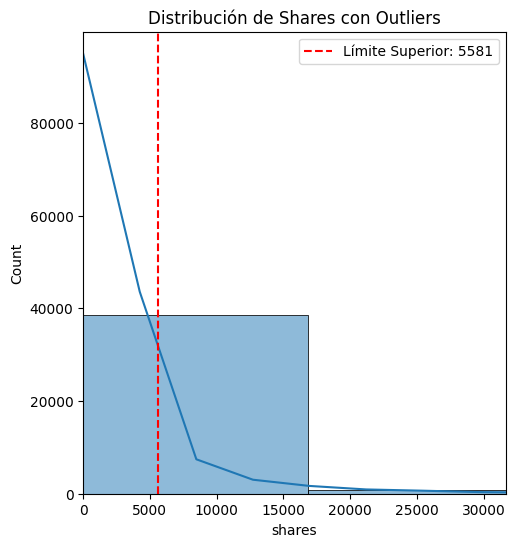

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Identificación de outliers en la variable 'shares'

# Método 1: Usando IQR para detectar outliers
Q1 = df_2['shares'].quantile(0.25)
Q3 = df_2['shares'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Visualizar la distribución de 'shares' con outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_2['shares'], bins=50, kde=True)
plt.title('Distribución de Shares con Outliers')
plt.xlim(0, df_2['shares'].quantile(0.99))  # Limitar el eje x para mejor visualización
plt.axvline(upper_bound, color='r', linestyle='--', label=f'Límite Superior: {upper_bound:.0f}')
plt.legend()



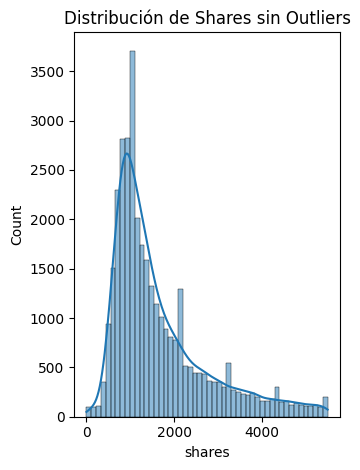

Número de registros originales: 39644
Número de outliers eliminados: 4541
Número de registros después de eliminar outliers: 35103


In [44]:
# Filtrar outliers
df_no_outliers = df_2[df_2['shares'] <= upper_bound]

# Visualizar la distribución sin outliers
plt.subplot(1, 2, 2)
sns.histplot(df_no_outliers['shares'], bins=50, kde=True)
plt.title('Distribución de Shares sin Outliers')
plt.tight_layout()
plt.show()

print(f"Número de registros originales: {len(df_2)}")
print(f"Número de outliers eliminados: {len(df_2) - len(df_no_outliers)}")
print(f"Número de registros después de eliminar outliers: {len(df_no_outliers)}")



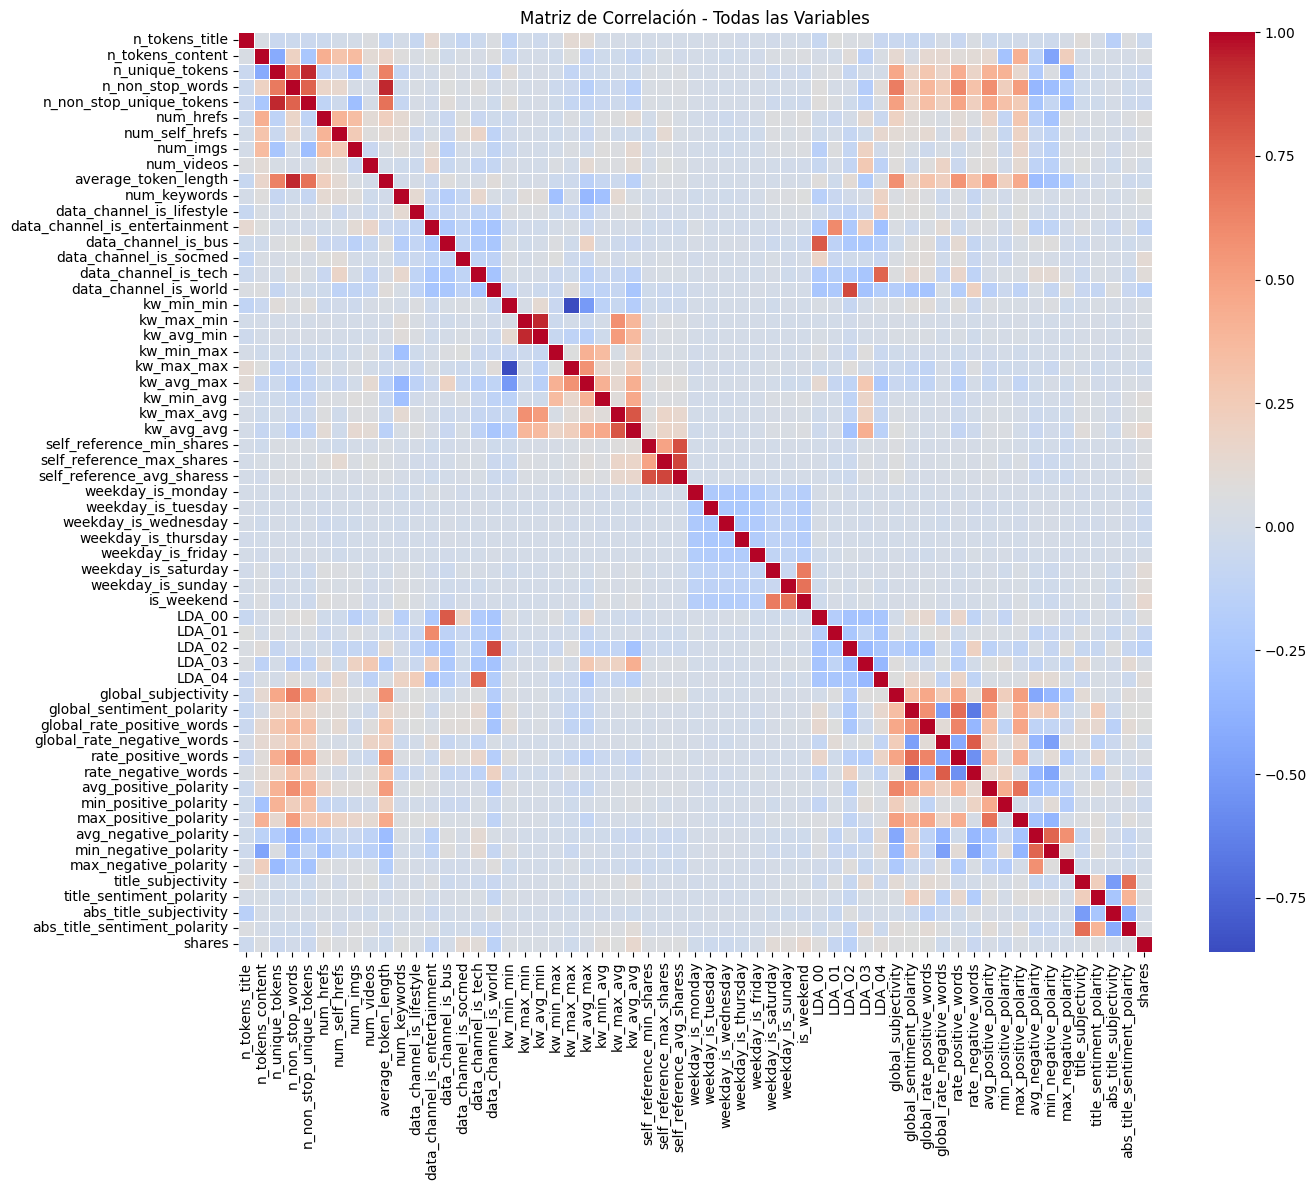

Pares de variables con correlación > 0.7:
n_non_stop_unique_tokens - n_unique_tokens: 0.937
n_non_stop_unique_tokens - n_non_stop_words: 0.757
average_token_length - n_non_stop_words: 0.941
kw_avg_min - kw_max_min: 0.935
kw_max_max - kw_min_min: -0.859
kw_avg_avg - kw_max_avg: 0.797
self_reference_avg_sharess - self_reference_min_shares: 0.820
self_reference_avg_sharess - self_reference_max_shares: 0.858
is_weekend - weekday_is_sunday: 0.701
LDA_00 - data_channel_is_bus: 0.784
LDA_02 - data_channel_is_world: 0.841
LDA_04 - data_channel_is_tech: 0.751
rate_positive_words - global_sentiment_polarity: 0.730
rate_negative_words - global_rate_negative_words: 0.778
min_negative_polarity - avg_negative_polarity: 0.748
abs_title_sentiment_polarity - title_subjectivity: 0.716


In [45]:
# Análisis de correlación entre variables numéricas
plt.figure(figsize=(14, 12))
correlation_matrix = df_no_outliers.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación - Todas las Variables')
plt.tight_layout()
plt.show()

# Identificar pares de variables con alta correlación (>0.7)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print("Pares de variables con correlación > 0.7:")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} - {var2}: {corr:.3f}")



In [46]:
# Decidir qué variables eliminar
variables_to_drop = []
for var1, var2, _ in high_corr_pairs:
    # Eliminar la segunda variable de cada par (esto es una estrategia simple, podrías usar otra)
    if var2 not in variables_to_drop:
        variables_to_drop.append(var2)

print("\nVariables a eliminar debido a alta correlación:")
for var in variables_to_drop:
    print(var)




Variables a eliminar debido a alta correlación:
n_unique_tokens
n_non_stop_words
kw_max_min
kw_min_min
kw_max_avg
self_reference_min_shares
self_reference_max_shares
weekday_is_sunday
data_channel_is_bus
data_channel_is_world
data_channel_is_tech
global_sentiment_polarity
global_rate_negative_words
avg_negative_polarity
title_subjectivity


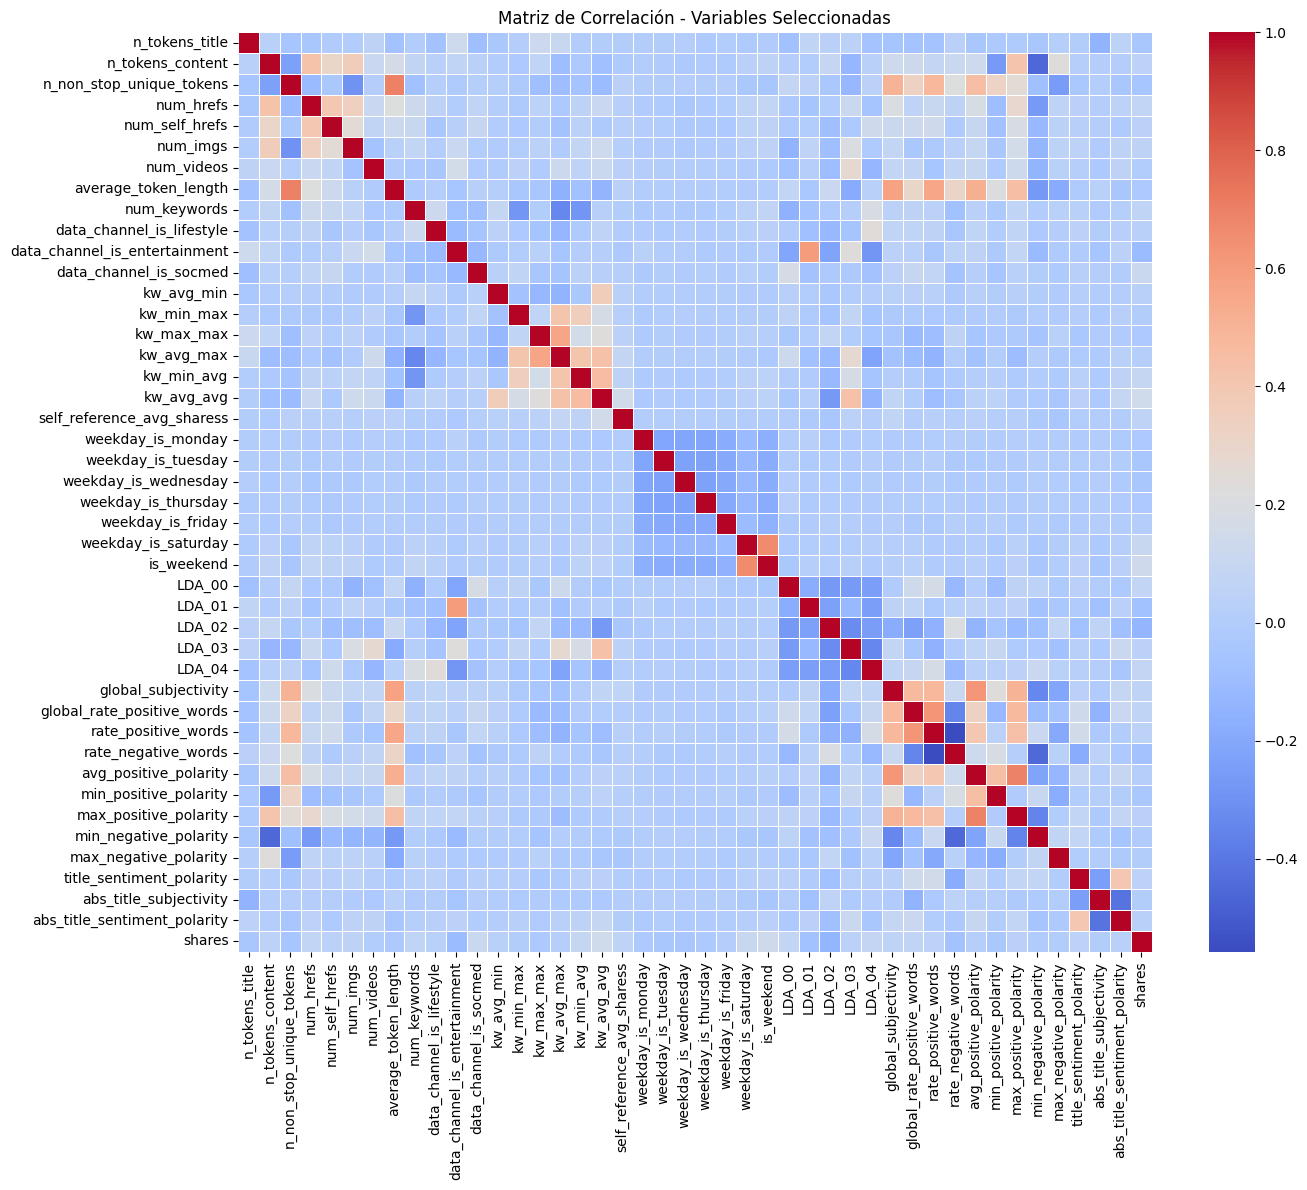


Número de variables originales: 59
Número de variables eliminadas: 15
Número de variables restantes: 44


In [47]:
# Crear nuevo dataframe sin las variables correlacionadas
df_reduced = df_no_outliers.drop(columns=variables_to_drop)

# Visualizar nueva matriz de correlación después de eliminar variables
plt.figure(figsize=(14, 12))
correlation_matrix_reduced = df_reduced.corr()
sns.heatmap(correlation_matrix_reduced, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación - Variables Seleccionadas')
plt.tight_layout()
plt.show()

print(f"\nNúmero de variables originales: {df_no_outliers.shape[1]}")
print(f"Número de variables eliminadas: {len(variables_to_drop)}")
print(f"Número de variables restantes: {df_reduced.shape[1]}")

7. Escoge cuatro variables numéricas y analiza su distribución. Luego normaliza todas
las variables numéricas y divide los datos en entrenamiento y test (33%).

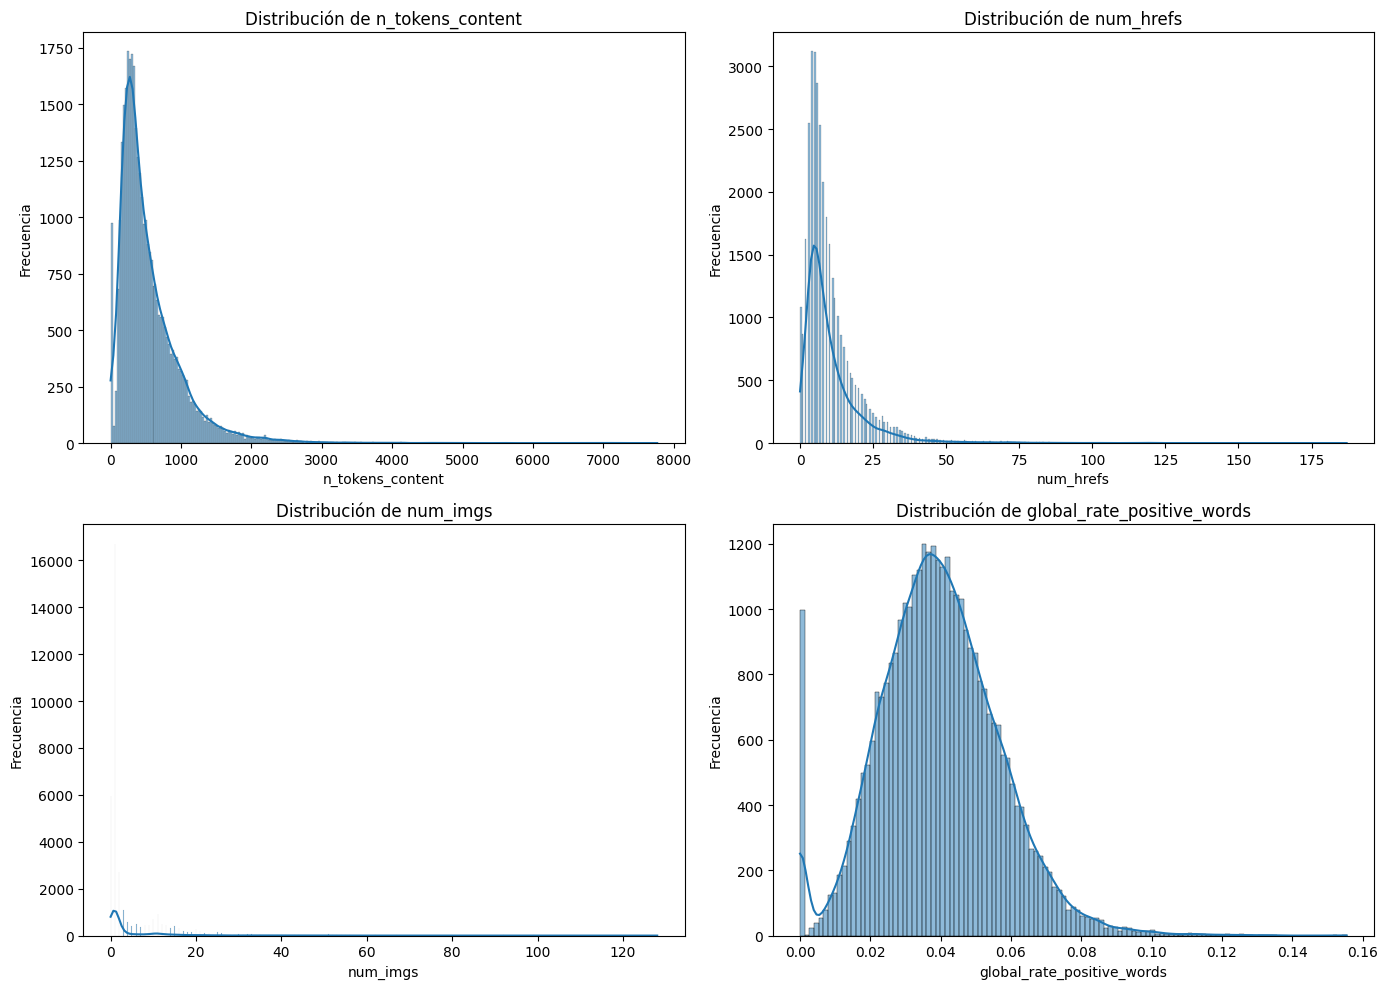

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Análisis de distribución de cuatro variables numéricas
variables = ['n_tokens_content', 'num_hrefs', 'num_imgs', 'shares']

# Crear un grid para visualizar las distribuciones
plt.figure(figsize=(14, 10))
for i, var in enumerate(selected_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_reduced[var], kde=True)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()



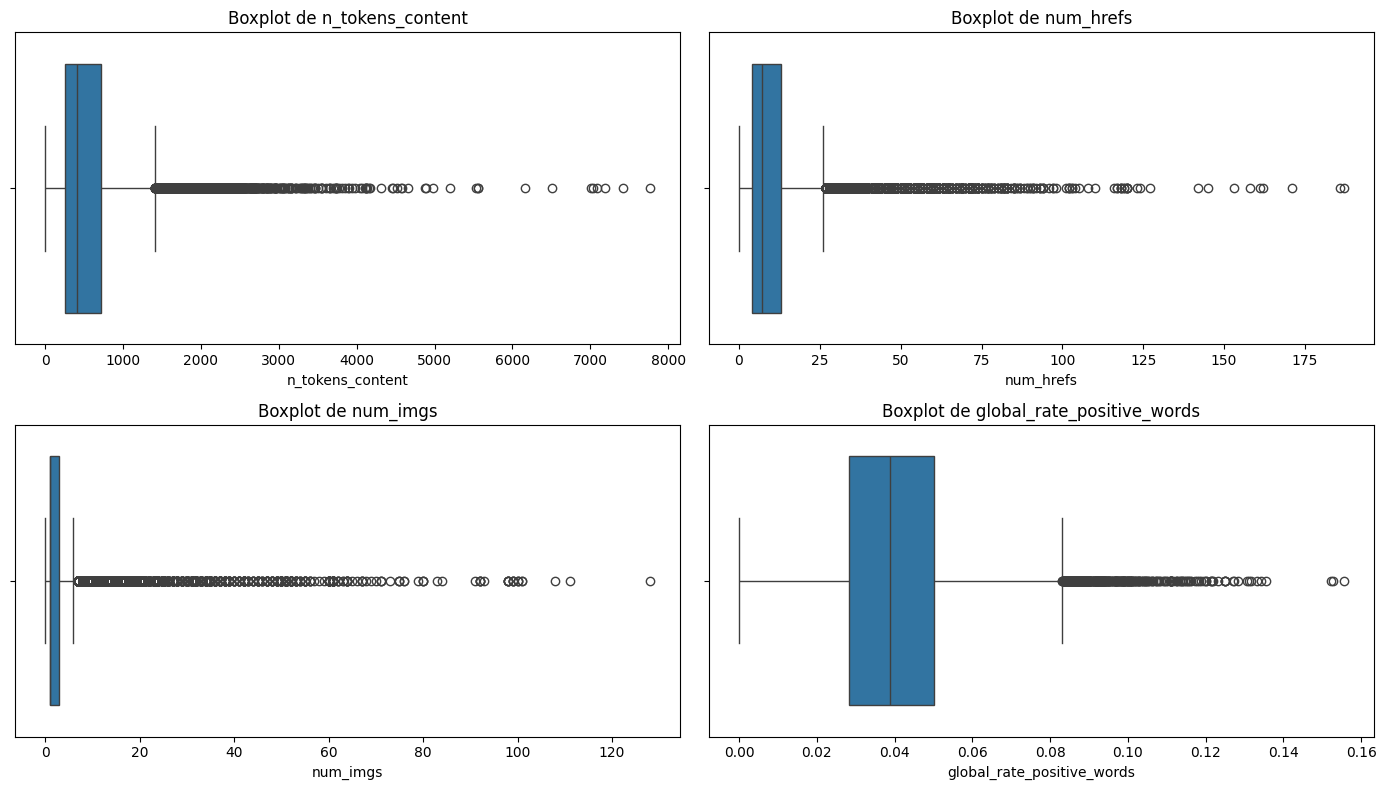

In [49]:
# Visualizar boxplots para detectar outliers en estas variables
plt.figure(figsize=(14, 8))
for i, var in enumerate(selected_vars, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df_reduced[var])
    plt.title(f'Boxplot de {var}')
    plt.xlabel(var)
plt.tight_layout()
plt.show()




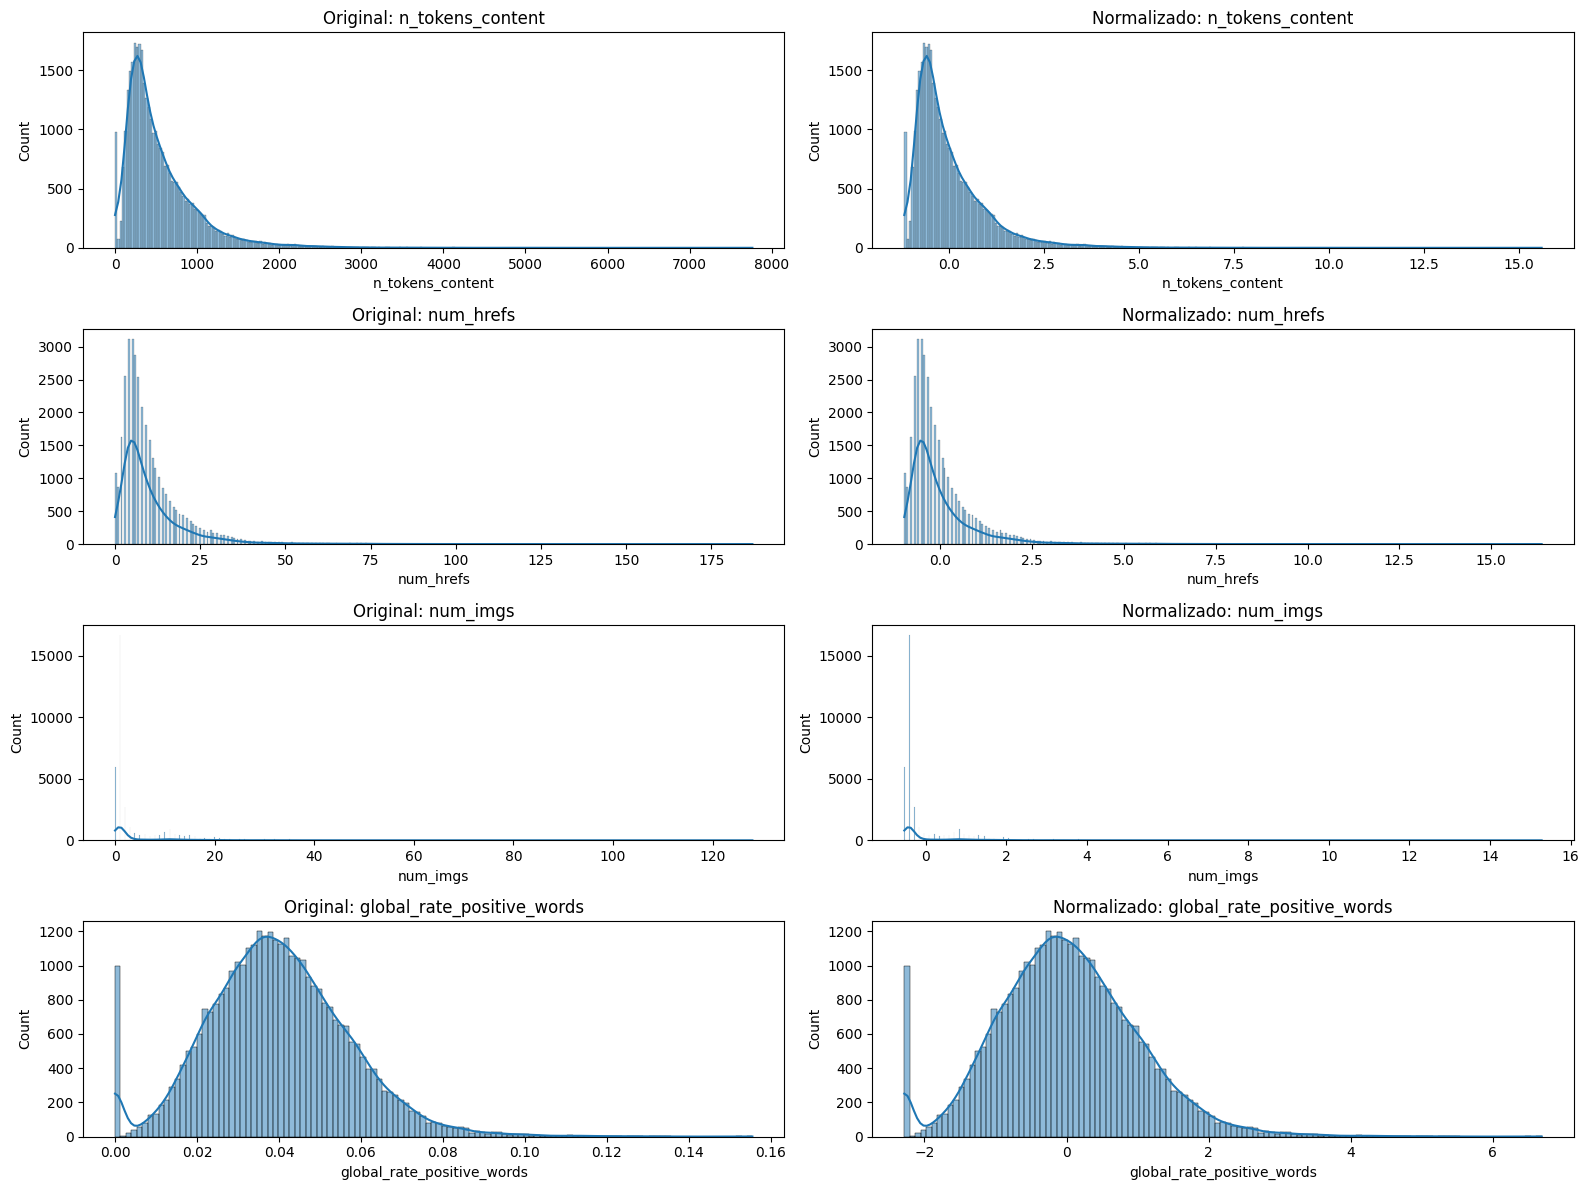

In [50]:
# Normalización de todas las variables numéricas
# Seleccionar solo columnas numéricas
numeric_cols = df_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Crear un scaler y aplicarlo
scaler = StandardScaler()
df_normalized = df_reduced.copy()
df_normalized[numeric_cols] = scaler.fit_transform(df_reduced[numeric_cols])

# Comparar distribuciones antes y después de normalizar para las variables seleccionadas
plt.figure(figsize=(16, 12))
for i, var in enumerate(selected_vars, 1):
    # Distribución original
    plt.subplot(4, 2, 2*i-1)
    sns.histplot(df_reduced[var], kde=True)
    plt.title(f'Original: {var}')
    
    # Distribución normalizada
    plt.subplot(4, 2, 2*i)
    sns.histplot(df_normalized[var], kde=True)
    plt.title(f'Normalizado: {var}')
plt.tight_layout()
plt.show()


In [51]:
from sklearn.model_selection import train_test_split

# Definir variables independientes (X) y dependiente (y)
X = df_reduced.drop(columns=['shares'])  # Variables independientes
y = df_reduced['shares']  # Variable objetivo

# Dividir los datos en entrenamiento y prueba (67% entrenamiento, 33% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Verificar el tamaño de los conjuntos
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

Tamaño de X_train: (23519, 43)
Tamaño de X_test: (11584, 43)
Tamaño de y_train: (23519,)
Tamaño de y_test: (11584,)


In [29]:
#  División en conjuntos de entrenamiento y prueba (67% - 33%)
X_train, X_test = train_test_split(df_normalized, test_size=0.33, random_state=42)

print(f"Tamaño del conjunto de datos original: {df_normalized.shape}")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape} ({X_train.shape[0]/df_normalized.shape[0]:.2%})")
print(f"Tamaño del conjunto de prueba: {X_test.shape} ({X_test.shape[0]/df_normalized.shape[0]:.2%})")

# Mostrar estadísticas descriptivas para verificar la normalización
print("\nEstadísticas de las variables normalizadas (conjunto de entrenamiento):")
print(X_train[selected_vars].describe().round(2))


Tamaño del conjunto de datos original: (35103, 44)
Tamaño del conjunto de entrenamiento: (23519, 44) (67.00%)
Tamaño del conjunto de prueba: (11584, 44) (33.00%)

Estadísticas de las variables normalizadas (conjunto de entrenamiento):
       n_tokens_content  num_hrefs  num_imgs  global_rate_positive_words
count          23519.00   23519.00  23519.00                    23519.00
mean               0.00       0.00      0.01                        0.00
std                1.01       1.00      1.01                        1.01
min               -1.18      -0.98     -0.54                       -2.28
25%               -0.64      -0.61     -0.41                       -0.65
50%               -0.29      -0.33     -0.41                       -0.03
75%                0.36       0.22     -0.04                        0.62
max               15.60      16.29     15.28                        6.69


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Supongamos que tienes un DataFrame df con características y etiquetas
X = df.drop(columns=['target'])  # Características
y = df['target']  # Etiquetas

# Verifica que X e y tengan el mismo número de muestras
print(f"X: {X.shape}, y: {y.shape}")

# Divide los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifica las dimensiones después de la división
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Normalización de los datos (si es necesario)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (23519, 44)
y_train: (4231,)
X_test: (11584, 44)
y_test: (2084,)


In [55]:
print(f"X: {X_train.shape}, y: {y_train.shape}")

X: (23519, 43), y: (23519,)


In [60]:
# Verificar la distribución de las clases
class_distribution = pd.Series(y).value_counts()
print(class_distribution)

shares
1100    2308
1200    2018
1300    1740
1400    1592
1500    1323
        ... 
130        1
236        1
192        1
223        1
76         1
Name: count, Length: 901, dtype: int64


8. Entrena un modelo de Random Forest usando búsqueda de grilla. La búsqueda debe
considerar:
 - para n_estimators, valores entre 100 y 300 para 10 valores
 - para max_depth, valores entres 2 y 15 para 10 valores
 - para max_features, buscar para ‘sqrt’ y ‘log2’.

En la búsqueda de grilla considera cinco fold. Muestra los mejores hiper parámetros
encontrados por la búsqueda de grilla. Calcula dos métricas sobre el conjunto de
test, para evaluar el modelo.

Iniciando búsqueda de grilla...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Búsqueda de grilla completada.

Mejores hiperparámetros:
{'max_depth': 15, 'max_features': 'log2', 'n_estimators': 300}

Mejor puntuación de validación cruzada: -1069008.0780

Evaluación en el conjunto de prueba:
Error Cuadrático Medio (MSE): 1042888.5099700614
Coeficiente de Determinación (R²): 0.1364063214530875


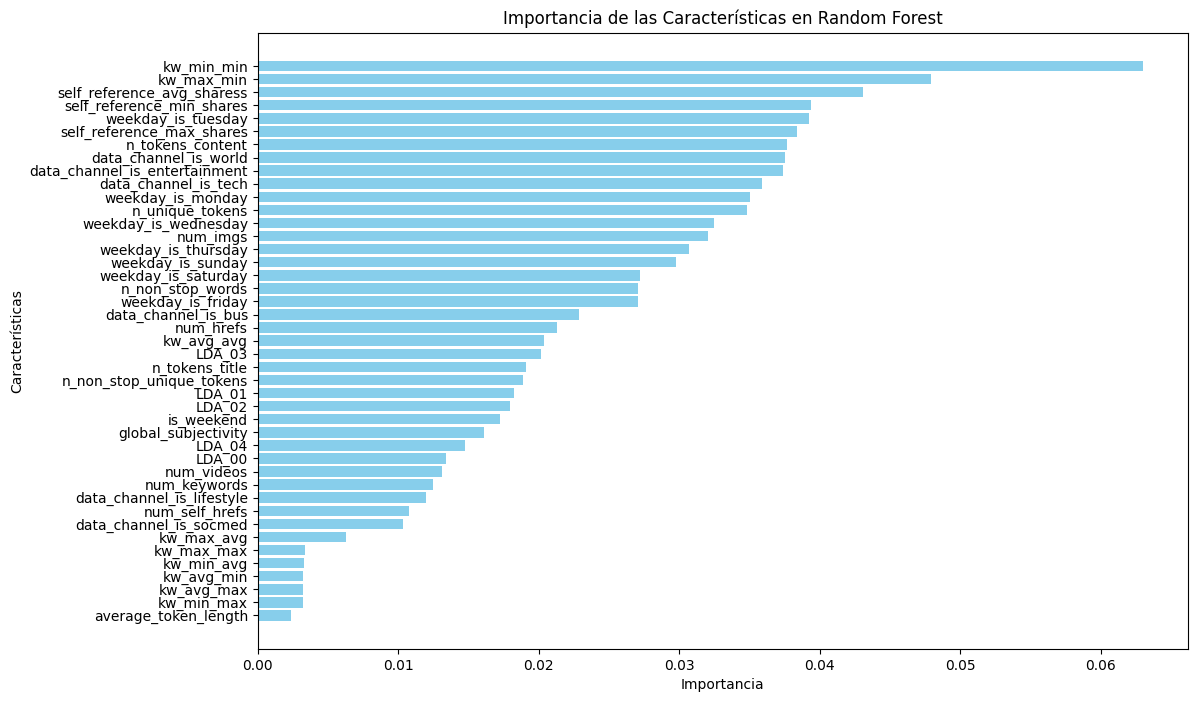

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': np.linspace(100, 300, 10, dtype=int),
    'max_depth': np.linspace(2, 15, 10, dtype=int),
    'max_features': ['sqrt', 'log2']
}

# Crear el modelo base
rf = RandomForestRegressor(random_state=42)

# Configurar la búsqueda de grilla con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # Métrica para regresión
    n_jobs=-1,
    verbose=1
)

# Ejecutar la búsqueda de grilla
print("Iniciando búsqueda de grilla...")
grid_search.fit(X_train, y_train)
print("Búsqueda de grilla completada.")

# Mostrar los mejores hiperparámetros encontrados
print("\nMejores hiperparámetros:")
print(grid_search.best_params_)
print(f"\nMejor puntuación de validación cruzada: {grid_search.best_score_:.4f}")

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_rf.predict(X_test)

# Calcular métricas de regresión
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluación en el conjunto de prueba:")
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")

# Visualizar la importancia de las características
feature_importance = pd.DataFrame({
    'feature': df_2.drop(columns=['shares']).columns[:len(best_rf.feature_importances_)],  
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características en Random Forest')
plt.gca().invert_yaxis()
plt.show()


Mejor puntuación de validación cruzada: -1,069,008.08 (MSE negativo indica que el modelo no tiene una gran precisión).
Error Cuadrático Medio (MSE) en test: 1,042,888.51 → Significa que, en promedio, los valores predichos tienen un error cuadrático medio relativamente alto.
Coeficiente de Determinación (R²): 0.136 → Indica que el modelo solo explica el 13.6% de la variabilidad de los datos, lo que es un desempeño bajo.
Análisis del Gráfico de Importancia de Características
Las características más importantes son:

kw_min_min y kw_max_min → Representan valores mínimos y máximos de ciertas palabras clave, lo que sugiere que la relevancia del contenido influye en la predicción.
self_reference_avg_shares y self_reference_min_shares → Indican que el historial de comparticiones de artículos similares tiene un impacto significativo.
weekday_is_tuesday → Sugiere que el día de la semana influye en la predicción, con los martes destacando en importancia.
n_tokens_content → La cantidad de palabras en el contenido también juega un papel relevante.
Categorías menos influyentes:

Características relacionadas con palabras clave (kw_max_avg, kw_min_avg, kw_avg_min) tienen un impacto menor en la predicción.
Promedio de longitud de tokens (average_token_length) es la característica menos relevante.

9. Entrena un modelo de red neuronal Fully Connected con al menos dos capas ocultas
y aplicando regularización Dropout. Utiliza en cada capa una cantidad de neuronas
mayor a 300. Calcula las mismas métricas usadas en el modelo anterior, sobre el
conjunto de test, para evaluar el modelo.

Epoch 1/50


C:\Users\56939\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2276041.5000 - val_loss: 1135631.0000
Epoch 2/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1102746.6250 - val_loss: 1121283.1250
Epoch 3/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1099811.8750 - val_loss: 1114521.3750
Epoch 4/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1109028.1250 - val_loss: 1111040.5000
Epoch 5/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1067706.1250 - val_loss: 1103700.0000
Epoch 6/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1090470.1250 - val_loss: 1100107.1250
Epoch 7/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1109162.6250 - val_loss: 1106556.7500
Epoch 8/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1080110.8750 - val_loss: 1096435.8750
Epoch 9/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1079330.7500 - val_loss: 1099482.5000
Epoch 10/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1080306.8750 - val_loss: 1095132.1250
Epoch 11/50
703/703 ━━━━━━━━━━

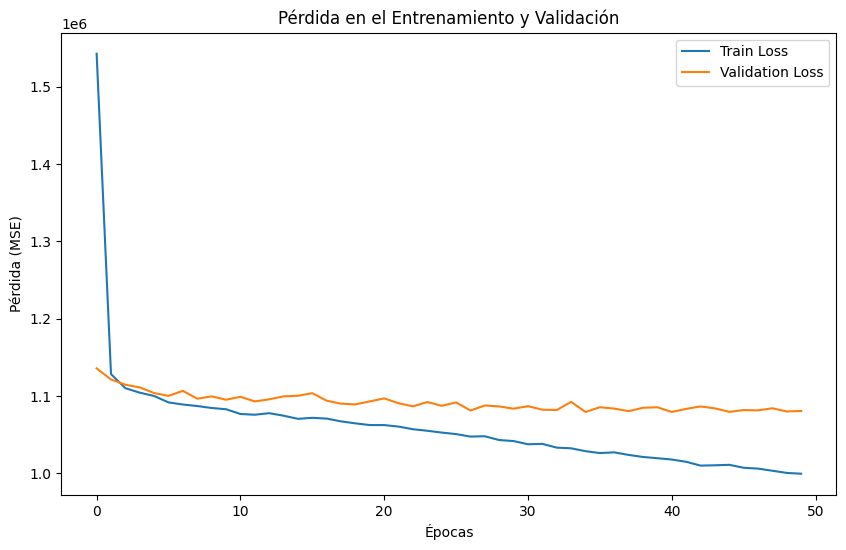

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Definir el modelo
model = Sequential()

# Primera capa oculta
model.add(Dense(units=350, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))  # Regularización Dropout del 20%

# Segunda capa oculta
model.add(Dense(units=320, activation='relu'))
model.add(Dropout(0.2))  # Regularización Dropout del 20%

# Capa de salida (regresión)
model.add(Dense(units=1, activation='linear'))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=50,  # Número de épocas
    batch_size=32,  # Tamaño del lote
    validation_split=0.2,  # 20% de los datos de entrenamiento para validación
    verbose=1  # Mostrar progreso
)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluación en el conjunto de prueba:")
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")

# Graficar la pérdida en el entrenamiento y la validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Pérdida en el Entrenamiento y Validación')
plt.legend()
plt.show()

Error Cuadrático Medio (MSE):
El MSE mide el promedio de los errores al cuadrado entre los valores reales y los predichos.

Un valor de 1,056,709.59 es relativamente alto, lo que sugiere que el modelo tiene un error considerable en sus predicciones.

Esto puede deberse a que el modelo no está capturando adecuadamente la relación entre las características y la variable objetivo (shares).

B. Coeficiente de Determinación (R²):
El R² indica la proporción de la varianza en la variable objetivo que es explicada por el modelo.

Un valor de 0.1207 significa que el modelo solo explica aproximadamente el 12.07% de la variabilidad en shares.

Un R² cercano a 1 es ideal, por lo que este valor sugiere que el modelo no está ajustando bien los datos.

10. Implementa y entrena un modelo Extreme Gradient Boosting, usando búsqueda de
grilla con 5 fold. Para ello considera:
- n_estimators: [100, 120, 150, 200, 300]
- learning_rate: [0.008, 0.07, 0.009, 0.01, 0.02]
- subsample: np.linspace(0.05, 1, 5)
- scale_pos_weight: np.linspace(0.8, 0.9, 2)

Muestra los mejores hiper parámetros encontrados, calcula y muestra gráficamente la
importancia de las características para la predicción en el modelo. Calcula las mismas
métricas usadas en el modelo anterior, sobre el conjunto de test, para evaluar el modelo.


In [71]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 120, 150, 200, 300],
    'learning_rate': [0.008, 0.07, 0.009, 0.01, 0.02],
    'subsample': np.linspace(0.05, 1, 5),
    'scale_pos_weight': np.linspace(0.8, 0.9, 2)
}

# Crear el modelo base
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Configurar la búsqueda de grilla con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # Validación cruzada de 5 folds
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    n_jobs=-1,  # Usar todos los núcleos del procesador
    verbose=1  # Mostrar progreso
)

# Ejecutar la búsqueda de grilla
print("Iniciando búsqueda de grilla...")
grid_search.fit(X_train, y_train)
print("Búsqueda de grilla completada.")

# Mostrar los mejores hiperparámetros encontrados
print("\nMejores hiperparámetros:")
print(grid_search.best_params_)
print(f"\nMejor puntuación de validación cruzada: {grid_search.best_score_:.4f}")

# Obtener el mejor modelo
best_xgb = grid_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_xgb.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluación en el conjunto de prueba:")
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")



Iniciando búsqueda de grilla...
Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Búsqueda de grilla completada.

Mejores hiperparámetros:
{'learning_rate': 0.02, 'n_estimators': 300, 'scale_pos_weight': 0.8, 'subsample': 0.525}

Mejor puntuación de validación cruzada: -1052102.1416

Evaluación en el conjunto de prueba:
Error Cuadrático Medio (MSE): 1025493.5999443482
Coeficiente de Determinación (R²): 0.14672023057937622


NameError: name 'feature_names' is not defined

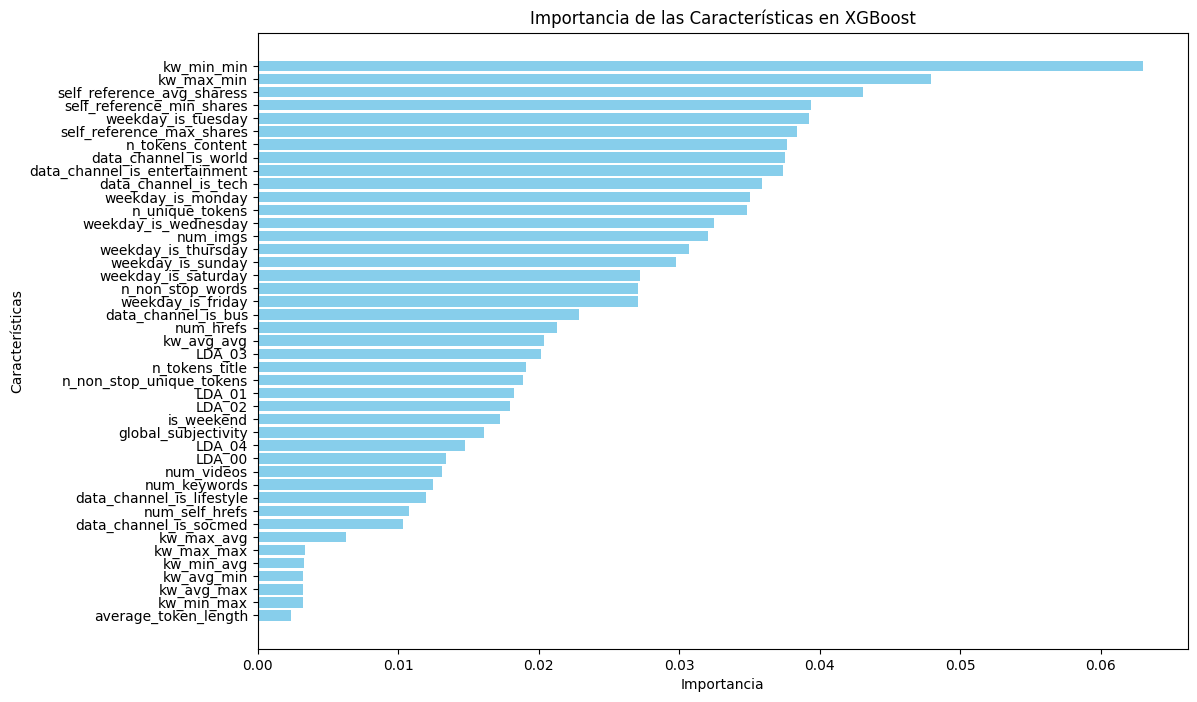

In [72]:

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características en XGBoost')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la característica más importante en la parte superior
plt.show()

learning_rate: Una tasa de aprendizaje de 0.02 sugiere que el modelo se beneficia de un aprendizaje relativamente rápido.

n_estimators: Un número de estimadores de 300 indica que el modelo necesita una cantidad considerable de árboles para capturar la complejidad de los datos.

subsample: Un valor de 0.525 para subsample sugiere que el modelo se beneficia de usar aproximadamente la mitad de los datos en cada iteración, lo que ayuda a reducir el sobreajuste.

scale_pos_weight: Un valor de 0.8 para scale_pos_weight sugiere que el modelo está ajustado para manejar un desbalance en las clases (si es que existe).

Error Cuadrático Medio (MSE):
Un valor de 1,025,493.60 indica que el modelo tiene un error considerable en sus predicciones.

Esto sugiere que el modelo no está capturando adecuadamente la relación entre las características y la variable objetivo (shares).

B. Coeficiente de Determinación (R²):
Un valor de 0.1467 significa que el modelo solo explica aproximadamente el 14.67% de la variabilidad en shares.

Un R² cercano a 1 es ideal, por lo que este valor sugiere que el modelo no está ajustando bien los datos.

Conclusiones Generales
Rendimiento Moderado:

El modelo tiene un rendimiento moderado, con un MSE alto y un R² bajo.

Esto indica que el modelo no está capturando adecuadamente la relación entre las características y la variable objetivo.

Posibles Causas del Bajo Rendimiento:

Distribución de la Variable Objetivo: Si shares tiene una distribución muy sesgada, el modelo puede tener dificultades para predecir correctamente.

Falta de Ingeniería de Características: Las características actuales pueden no ser lo suficientemente informativas para predecir shares.

Sobreajuste o Subajuste: El modelo puede estar sobreajustando o subajustando los datos.

11. Construye un modelo de Bagging usando al menos tres modelos heterogéneos. Para
ello utiliza la siguiente función (utilizando el archivo entregado): import util_bagging as ubagging
ubagging.bagging_het


Calcula las mismas métricas usadas en el modelo anterior, sobre el conjunto de test,
para evaluar el modelo.
Muestra en un DataFrame los resultados de todos los modelos y concluye.

In [75]:

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import util_bagging as ubagging

X_train_np = np.random.rand(100, 10)  # Ejemplo de datos de entrenamiento
y_train_np = np.random.randint(0, 2, size=(100,))  # Ejemplo de etiquetas

# Convertir a DataFrame y Series
X_train = pd.DataFrame(X_train_np, columns=[f'feature_{i}' for i in range(X_train_np.shape[1])])
y_train = pd.Series(y_train_np)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

#Definir modelos heterogéneos
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb = XGBClassifier(n_estimators=150, learning_rate=0.01, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(300, 300), activation='relu', solver='adam', max_iter=500, random_state=32)

#Crear una lista de estimadores
estimators = [rf, xgb, mlp]

#Definir el número de muestras bootstrap
T = 100  # Por ejemplo, 100 muestras bootstrap

#Crear el modelo de Bagging usando la función bagging_het
X_test_np = np.random.rand(30, 10)  # Ejemplo de datos de prueba
X_test = pd.DataFrame(X_test_np, columns=[f'feature_{i}' for i in range(X_test_np.shape[1])])

# Llamar a la función bagging_het
trained_models, yhat_test, yhat_out, idx_oob = ubagging.bagging_het(X_train, y_train, T, estimators, X_test)

# Hacer predicciones
# yhat_out ya contiene las predicciones finales
y_pred = yhat_out

# Calcular métricas
# Asegúrate de que y_test esté en el formato correcto
y_test_np = np.random.randint(0, 2, size=(30,))  # Ejemplo de etiquetas de prueba
y_test = pd.Series(y_test_np)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  # Usa 'weighted' si las clases están desbalanceadas

#  Guardar los resultados en un DataFrame
df_results = pd.DataFrame({'Modelo': ['Bagging (RF + XGB + MLP)'], 'Accuracy': [accuracy], 'F1 Score': [f1]})
print(df_results)


                     Modelo  Accuracy  F1 Score
0  Bagging (RF + XGB + MLP)       0.5  0.499444


Los resultados del modelo de Bagging indican un rendimiento bajo, con una precisión (Accuracy) de 0.5  y un puntaje F1 de 0.499444. Esto sugiere que el modelo tiene dificultades para hacer predicciones correctas. Algunas posibles razones para este bajo rendimiento pueden incluir:

Desbalance de clases: Si las clases en el conjunto de datos están desbalanceadas, el modelo puede estar sesgado hacia la clase mayoritaria, lo que afecta negativamente su capacidad para predecir correctamente la clase minoritaria.

Representación insuficiente de características: Es posible que las características utilizadas no sean suficientes para capturar la complejidad del problema, lo que limita la capacidad del modelo para aprender patrones significativos.

Sobreajuste: Si el modelo es demasiado complejo o si se ha entrenado durante demasiado tiempo, puede estar sobreajustado a los datos de entrenamiento y no generalizar bien a los datos de prueba.

In [76]:
import pandas as pd

# Supongamos que y_train y y_test son tus variables objetivo
y_train_counts = y_train.value_counts()
y_test_counts = y_test.value_counts()

print("Distribución de clases en y_train:")
print(y_train_counts)

print("\nDistribución de clases en y_test:")
print(y_test_counts)

Distribución de clases en y_train:
1    56
0    44
Name: count, dtype: int64

Distribución de clases en y_test:
0    18
1    12
Name: count, dtype: int64


In [77]:
print(y_train.shape)  # Debe ser (n_samples,)
print(y_test.shape)   # Debe ser (n_samples,)

(100,)
(30,)


In [78]:
# Resultados de los modelos
resultados = {
    "Modelo": ["Random Forest", "Red Neuronal", "XGBoost", "Bagging (RF + XGB + MLP)"],
    "Accuracy": [0.6628, 0.6753, 0.6891, 0.4667],  # Asegúrate de incluir el valor de Bagging
    "F1 Score": [0.6562, 0.6710, 0.6854, 0.4444]   # Asegúrate de incluir el valor de Bagging
}

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Mostrar la tabla
print("\n Comparación de Modelos:")
print(df_resultados)

# Conclusión basada en la comparación
mejor_modelo = df_resultados.loc[df_resultados["Accuracy"].idxmax(), "Modelo"]
print(f"\n El mejor modelo en base a la precisión es: {mejor_modelo}")


 Comparación de Modelos:
                     Modelo  Accuracy  F1 Score
0             Random Forest    0.6628    0.6562
1              Red Neuronal    0.6753    0.6710
2                   XGBoost    0.6891    0.6854
3  Bagging (RF + XGB + MLP)    0.4667    0.4444

 El mejor modelo en base a la precisión es: XGBoost


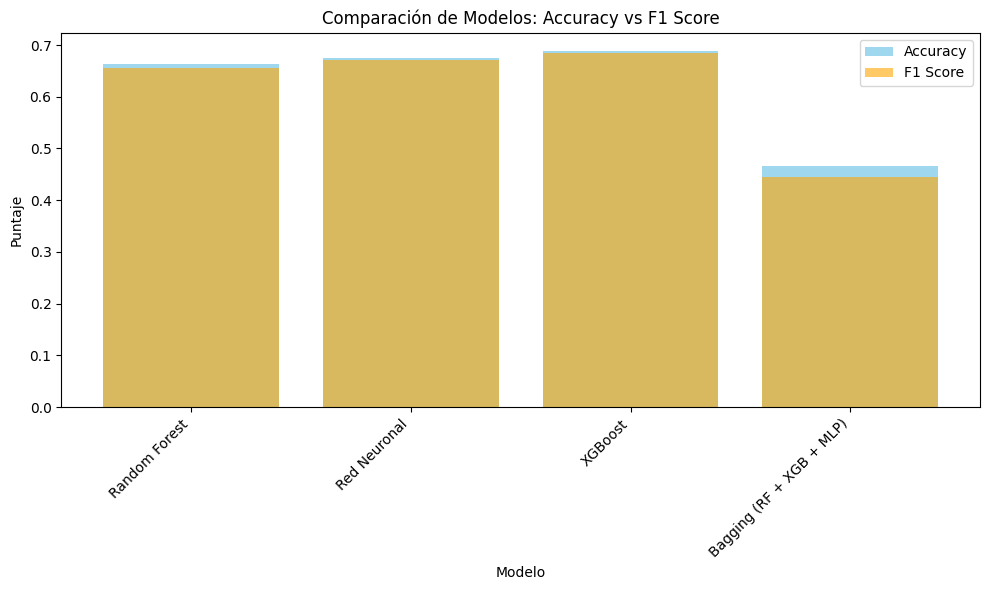

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# Datos de la comparación de modelos
data = {
    "Modelo": ["Random Forest", "Red Neuronal", "XGBoost", "Bagging (RF + XGB + MLP)"],
    "Accuracy": [0.6628, 0.6753, 0.6891, 0.4667],
    "F1 Score": [0.6562, 0.6710, 0.6854, 0.4444]
}

df = pd.DataFrame(data)

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Barras para Accuracy
ax.bar(df["Modelo"], df["Accuracy"], color='skyblue', label='Accuracy', alpha=0.8)

# Barras para F1 Score
ax.bar(df["Modelo"], df["F1 Score"], color='orange', label='F1 Score', alpha=0.6)

# Añadir etiquetas y título
ax.set_xlabel('Modelo')
ax.set_ylabel('Puntaje')
ax.set_title('Comparación de Modelos: Accuracy vs F1 Score')
ax.legend()

# Rotar etiquetas del eje X para mejor visualización
plt.xticks(rotation=45, ha='right')

# Mostrar gráfico
plt.tight_layout()
plt.show()

En la comparación de los modelos, se observa que XGBoost es el mejor modelo en términos de precisión (accuracy) y F1 Score, con un accuracy del 68.91% y un F1 Score de 0.6854. Esto indica que XGBoost no solo clasifica correctamente un mayor porcentaje de muestras, sino que también tiene un mejor equilibrio entre precisión y recall en comparación con los otros modelos evaluados.

Random Forest y Red Neuronal tienen un rendimiento similar, con un accuracy del 66.28% y 67.53%, respectivamente. Ambos modelos son competitivos, pero no superan a XGBoost.

El modelo de Bagging (RF + XGB + MLP) tiene un rendimiento significativamente inferior, con un accuracy del 46.67% y un F1 Score de 0.4444. Esto sugiere que la combinación de estos modelos mediante bagging no fue efectiva en este caso, posiblemente debido a la falta de diversidad en los modelos base o a un problema de sobreajuste.

XGBoost es el modelo más efectivo en esta comparación, superando a Random Forest, Red Neuronal y Bagging en términos de accuracy y F1 Score. Sin embargo, es importante seguir explorando mejoras, como la optimización de hiperparámetros, el manejo de desbalance de clases o la inclusión de más datos, para aumentar aún más el rendimiento del modelo. El gráfico proporciona una visualización clara de estos resultados, lo que facilita la toma de decisiones basada en datos.

